# Initial Preparation

In [123]:
# data handling
import pandas as pd 
import numpy as np 
from datetime import datetime, timedelta
import scipy 
import math 
import time

# visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

# pickle 
import pickle 

# sklearn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score

# pytorch 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data 
from torch.autograd import Variable
import torch.optim as optim 

# optuna 
import optuna 

In [124]:
SEED = 1
TIME_STEP = timedelta(hours = 1)

# check for GPU 
DEVICE = 'cpu'
cuda = torch.cuda.is_available()
if cuda: 
    print('cuda available..')
    DEVICE = 'cuda'
    torch.cuda.manual_seed(SEED)
print(f'Device: {DEVICE}')

cuda available..
Device: cuda


# Data Notes
---
Files (by fishing gear types):  
1. Drifting longline vessels 
2. Fixed gear vessels 
3. Pole and line vessels 
4. Purse seines vessels
5. Trawler vessels 
6. Troller vessels 
7. Vessels with unknown gear types  
  
CSV Table Schema:  
- mmsi ([Maritime Mobile Service Identity](https://en.wikipedia.org/wiki/Maritime_Mobile_Service_Identity)): anonymized vessel identifier
- timestamp: unix timestamp
- distance_from_shore: distance from shore in meters
- distance_from_port: distance from port in meters
- speed: vessel speed in knots
- course: vessel's course over ground (represented in degrees)
    - Some records will have course values of 511, which is larger than the maximum value of 360 degrees. That means the data is not available according to the [US Coast Guard Class A AIS Position Report Documentation](https://www.navcen.uscg.gov/?pageName=AISMessagesA).
- lat: latitude in decimal degrees
- lon: longitude in decimal degrees
- is_fishing: lable indicating fishing activity
    - 0 = not fishing
    - \> 0 = fishing; data values between 0 and 1 indicate the average score for the position if scored by multiple people
    - -1 = no data
- source: the training data batch; data was prepared by GFW, Dalhousie, and a crowd sourcing campaign (false positives are marked as false_positives)

In [125]:
# filepaths 
drifting_longlines_file = './data/drifting_longlines.csv'
fixed_gear_file = './data/fixed_gear.csv'
pole_and_line_file = './data/pole_and_line.csv'
purse_seines_file = './data/purse_seines.csv'
trawlers_file = './data/trawlers.csv'
trollers_file = './data/trollers.csv'
unknown_file = './data/unknown.csv'

# for mapping vessel paths later 
# ocean_map = gpd.read_file('./mapping/world_map/ne_50m_ocean.shp')
# south_atlantic = gpd.read_file('./mapping/south_atlantic/iho.shp')
# bornholm = gpd.read_file('./mapping/bornholm/europeislands.shp')
# arrecife = gpd.read_file('./mapping/north_atlantic/iho.shp')
# phillippine_sea = gpd.read_file('./mapping/phillippine_sea/iho.shp')
# north_pacific = gpd.read_file('./mapping/north_pacific/eez_iho.shp')
# crs = {'init': 'epsg:4326'}

# Exploratory Analysis / Initial Data Wrangling on Separated Datasets  
---  
  


## Drifting Longlines


In [126]:
# read in data from the drifting long line vessel file 
drifting_longlines_df = pd.read_csv(drifting_longlines_file)

# peak at the data
drifting_longlines_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.263956e+13,1.327137e+09,232994.281250,311748.65625,8.2,230.500000,14.865583,-26.853662,-1.0,dalhousie_longliner
1,1.263956e+13,1.327137e+09,233994.265625,312410.34375,7.3,238.399994,14.863870,-26.856800,-1.0,dalhousie_longliner
2,1.263956e+13,1.327137e+09,233994.265625,312410.34375,6.8,238.899994,14.861551,-26.860649,-1.0,dalhousie_longliner
3,1.263956e+13,1.327143e+09,233994.265625,315417.37500,6.9,251.800003,14.822686,-26.865898,-1.0,dalhousie_longliner
4,1.263956e+13,1.327143e+09,233996.390625,316172.56250,6.1,231.100006,14.821825,-26.867579,-1.0,dalhousie_longliner


In [127]:
# check data characteristics 
drifting_longlines_df.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.396873e+07,1.396873e+07,1.396873e+07,1.396873e+07,1.396863e+07,1.396863e+07,1.396873e+07,1.396873e+07,1.396873e+07
mean,1.293850e+14,1.434290e+09,5.845311e+05,7.897505e+05,5.464779e+00,1.814876e+02,-8.997629e+00,3.758693e+00,-9.743015e-01
std,7.887357e+13,3.984275e+07,5.420068e+05,6.915438e+05,4.043567e+00,1.050503e+02,2.439311e+01,1.095971e+02,2.119947e-01
min,5.601266e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.519017e+01,-1.800000e+02,-1.000000e+00
25%,6.260384e+13,1.410706e+09,1.019092e+05,2.130206e+05,2.100000e+00,9.070000e+01,-2.601550e+01,-8.808668e+01,-1.000000e+00
50%,1.184859e+14,1.447302e+09,4.576393e+05,6.375249e+05,5.500000e+00,1.811000e+02,-1.497954e+01,-1.716495e+00,-1.000000e+00
75%,1.980758e+14,1.466506e+09,9.603664e+05,1.210432e+06,8.500000e+00,2.711000e+02,4.485790e+00,1.009811e+02,-1.000000e+00
max,2.812058e+14,1.480032e+09,4.430996e+06,7.181037e+06,1.023000e+02,5.110000e+02,8.333266e+01,1.799938e+02,1.000000e+00


In [128]:
# data shape 
drifting_longlines_df.shape

(13968727, 10)

In [129]:
# drop rows without data for is_fishing 
drifting_longlines_df = drifting_longlines_df[drifting_longlines_df['is_fishing'] != -1]

# recheck data shape
drifting_longlines_df.shape

(219741, 10)

In [130]:
# check label distribution 
drifting_longlines_df['is_fishing'].value_counts()

1.000000    138163
0.000000     79574
0.666667      1076
0.333333       809
0.750000       110
0.250000         9
Name: is_fishing, dtype: int64

In [131]:
# recheck data characteristics after dropping rows missing is_fishing data 
drifting_longlines_df.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,2.197410e+05,2.197410e+05,2.197410e+05,2.197410e+05,219741.000000,219741.000000,219741.000000,219741.000000,219741.000000
mean,1.368067e+14,1.413013e+09,5.113833e+05,7.021433e+05,5.687254,181.330646,-8.010195,4.203933,0.633631
std,8.173824e+13,1.594068e+07,4.882178e+05,6.183033e+05,3.787542,103.866320,23.478505,110.809452,0.479725
min,5.601266e+12,1.338572e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-45.302502,-179.999115,0.000000
25%,6.260384e+13,1.407986e+09,9.338936e+04,1.684358e+05,2.600000,91.699997,-23.396667,-79.919830,0.000000
50%,1.220965e+14,1.411405e+09,4.179383e+05,5.699421e+05,5.700000,179.800003,-15.034370,2.768880,1.000000
75%,2.089256e+14,1.418502e+09,7.719319e+05,1.115062e+06,8.700000,271.399994,3.925500,73.103127,1.000000
max,2.812058e+14,1.451623e+09,2.185458e+06,3.117979e+06,102.300003,360.000000,73.066498,179.991486,1.000000


In [132]:
# check for null values 
drifting_longlines_df.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [133]:
# reformat unix timestamps into datetime
drifting_long_lines_formatted_timestamps = pd.to_datetime(drifting_longlines_df['timestamp'], unit = 's')
drifting_longlines_df.insert(2, 'timestamp_reformat', drifting_long_lines_formatted_timestamps)
drifting_longlines_df.head() 

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
330,1.263956e+13,1.338658e+09,2012-06-02 17:19:50,111123.328125,147593.812500,8.2,162.800003,18.608902,-17.205967,1.0,dalhousie_longliner
423,1.263956e+13,1.340094e+09,2012-06-19 08:12:54,329078.531250,362363.843750,5.0,333.899994,18.839836,-19.453779,1.0,dalhousie_longliner
570,1.263956e+13,1.345706e+09,2012-08-23 07:06:20,86831.046875,196301.062500,0.7,260.100006,19.276720,-17.323196,1.0,dalhousie_longliner
638,1.263956e+13,1.346391e+09,2012-08-31 05:24:34,98881.343750,166465.140625,4.2,43.400002,18.852455,-17.255033,1.0,dalhousie_longliner
677,1.263956e+13,1.346825e+09,2012-09-05 06:11:05,74247.757812,177480.859375,7.0,333.500000,19.101482,-17.147205,1.0,dalhousie_longliner


In [134]:
# add separate month, day of the week, year, and hour columns derived from timstamps
drifting_longlines_df.insert(3, 'year', drifting_longlines_df['timestamp_reformat'].dt.year)
# round to closest hour 
drifting_longlines_df.insert(4, 'hour', drifting_longlines_df['timestamp_reformat'].dt.round('H').dt.hour)
drifting_longlines_df.insert(5, 'day_of_week', drifting_longlines_df['timestamp_reformat'].dt.day_name())
drifting_longlines_df.insert(6, 'month', drifting_longlines_df['timestamp_reformat'].dt.month_name())

drifting_longlines_df.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
330,1.263956e+13,1.338658e+09,2012-06-02 17:19:50,2012,17,Saturday,June,111123.328125,147593.812500,8.2,162.800003,18.608902,-17.205967,1.0,dalhousie_longliner
423,1.263956e+13,1.340094e+09,2012-06-19 08:12:54,2012,8,Tuesday,June,329078.531250,362363.843750,5.0,333.899994,18.839836,-19.453779,1.0,dalhousie_longliner
570,1.263956e+13,1.345706e+09,2012-08-23 07:06:20,2012,7,Thursday,August,86831.046875,196301.062500,0.7,260.100006,19.276720,-17.323196,1.0,dalhousie_longliner
638,1.263956e+13,1.346391e+09,2012-08-31 05:24:34,2012,5,Friday,August,98881.343750,166465.140625,4.2,43.400002,18.852455,-17.255033,1.0,dalhousie_longliner
677,1.263956e+13,1.346825e+09,2012-09-05 06:11:05,2012,6,Wednesday,September,74247.757812,177480.859375,7.0,333.500000,19.101482,-17.147205,1.0,dalhousie_longliner


In [135]:
# count the unique mmsi's 
len(pd.unique(drifting_longlines_df['mmsi']))

110

## Fixed Gear 

In [136]:
# read in the data from the fixed gear vessels file 
fixed_gear_df = pd.read_csv(fixed_gear_file)

# peak at data 
fixed_gear_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,7.572519e+12,1.347664e+09,0.0,36054.625000,0.0,0.000000,42.798748,-8.944992,-1.0,gfw
1,7.572519e+12,1.348056e+09,0.0,36054.625000,0.0,0.000000,42.798717,-8.945075,-1.0,gfw
2,7.572519e+12,1.350409e+09,0.0,90970.296875,0.0,198.199997,43.106419,-9.215466,-1.0,gfw
3,7.572519e+12,1.350410e+09,0.0,90970.296875,0.0,186.899994,43.106434,-9.215431,-1.0,gfw
4,7.572519e+12,1.350411e+09,0.0,90970.296875,0.0,190.500000,43.106430,-9.215442,-1.0,gfw


In [137]:
# check data characteristics
fixed_gear_df.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06
mean,1.530752e+14,1.421486e+09,3.761878e+04,5.989848e+04,2.227195e+00,1.877938e+02,5.095086e+01,1.274018e+00,-9.659100e-01
std,8.976383e+13,3.782830e+07,1.090188e+05,1.269729e+05,3.412790e+00,1.177506e+02,5.894565e+00,8.512244e+00,2.173124e-01
min,7.572519e+12,1.325625e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.326460e+01,-1.792441e+02,-1.000000e+00
25%,8.878018e+13,1.387594e+09,0.000000e+00,5.656715e+03,0.000000e+00,7.740000e+01,4.745566e+01,-3.909275e+00,-1.000000e+00
50%,1.305289e+14,1.427254e+09,0.000000e+00,2.690659e+04,1.000000e-01,2.055000e+02,5.050242e+01,-2.333808e+00,-1.000000e+00
75%,2.616830e+14,1.455255e+09,3.413126e+04,5.514391e+04,3.800000e+00,2.870000e+02,5.602126e+01,8.220293e+00,-1.000000e+00
max,2.802913e+14,1.480032e+09,3.099833e+06,1.181676e+07,1.023000e+02,5.110000e+02,8.479108e+01,1.709277e+02,1.000000e+00


In [138]:
# data shape
fixed_gear_df.shape

(1559137, 10)

In [139]:
# drop rows without data for is_fishing 
fixed_gear_df = fixed_gear_df[fixed_gear_df['is_fishing'] != -1]
fixed_gear_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
26358,7.572519e+12,1.420185e+09,38012.222656,103307.679688,1.8,29.000000,43.416580,-9.328747,0.0,gfw
26359,7.572519e+12,1.420185e+09,38909.199219,103389.921875,1.0,13.900000,43.418369,-9.326941,0.0,gfw
26360,7.572519e+12,1.420186e+09,38909.199219,103389.921875,0.8,28.500000,43.420197,-9.325145,0.0,gfw
26361,7.572519e+12,1.420187e+09,38909.199219,103389.921875,1.3,46.500000,43.421734,-9.323038,0.0,gfw
26362,7.572519e+12,1.420188e+09,38909.199219,103389.921875,0.7,217.300003,43.420063,-9.331503,0.0,gfw


In [140]:
# recheck data shape 
fixed_gear_df.shape

(41858, 10)

In [141]:
# check label distribution 
fixed_gear_df['is_fishing'].value_counts()

0.000000    29790
1.000000    10665
0.666667      538
0.250000      423
0.333333      405
0.800000       29
0.750000        6
0.400000        2
Name: is_fishing, dtype: int64

In [142]:
# check for null values 
fixed_gear_df.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [143]:
# reformat unix timestamps into datetime 
fixed_gear_formatted_timestamps = pd.to_datetime(fixed_gear_df['timestamp'], unit = 's')
fixed_gear_df.insert(2, 'timestamp_reformat', fixed_gear_formatted_timestamps)
fixed_gear_df.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
26358,7.572519e+12,1.420185e+09,2015-01-02 07:44:07,38012.222656,103307.679688,1.8,29.000000,43.416580,-9.328747,0.0,gfw
26359,7.572519e+12,1.420185e+09,2015-01-02 07:56:08,38909.199219,103389.921875,1.0,13.900000,43.418369,-9.326941,0.0,gfw
26360,7.572519e+12,1.420186e+09,2015-01-02 08:08:09,38909.199219,103389.921875,0.8,28.500000,43.420197,-9.325145,0.0,gfw
26361,7.572519e+12,1.420187e+09,2015-01-02 08:23:08,38909.199219,103389.921875,1.3,46.500000,43.421734,-9.323038,0.0,gfw
26362,7.572519e+12,1.420188e+09,2015-01-02 08:38:07,38909.199219,103389.921875,0.7,217.300003,43.420063,-9.331503,0.0,gfw


In [144]:
# add separate month, day of the week, year, and hour columns derived from timstamps
fixed_gear_df.insert(3, 'year', fixed_gear_df['timestamp_reformat'].dt.year)
# round to closest hour
fixed_gear_df.insert(4, 'hour', fixed_gear_df['timestamp_reformat'].dt.round('H').dt.hour)
fixed_gear_df.insert(5, 'day_of_week', fixed_gear_df['timestamp_reformat'].dt.day_name())
fixed_gear_df.insert(6, 'month', fixed_gear_df['timestamp_reformat'].dt.month_name())

fixed_gear_df.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
26358,7.572519e+12,1.420185e+09,2015-01-02 07:44:07,2015,8,Friday,January,38012.222656,103307.679688,1.8,29.000000,43.416580,-9.328747,0.0,gfw
26359,7.572519e+12,1.420185e+09,2015-01-02 07:56:08,2015,8,Friday,January,38909.199219,103389.921875,1.0,13.900000,43.418369,-9.326941,0.0,gfw
26360,7.572519e+12,1.420186e+09,2015-01-02 08:08:09,2015,8,Friday,January,38909.199219,103389.921875,0.8,28.500000,43.420197,-9.325145,0.0,gfw
26361,7.572519e+12,1.420187e+09,2015-01-02 08:23:08,2015,8,Friday,January,38909.199219,103389.921875,1.3,46.500000,43.421734,-9.323038,0.0,gfw
26362,7.572519e+12,1.420188e+09,2015-01-02 08:38:07,2015,9,Friday,January,38909.199219,103389.921875,0.7,217.300003,43.420063,-9.331503,0.0,gfw


In [145]:
# count the unique mmsi's 
len(pd.unique(fixed_gear_df['mmsi']))

36

## Pole and Lines 

In [146]:
# read in data from the pole and lines vessel file
pole_and_lines_df = pd.read_csv(pole_and_line_file)

# peak at the data 
pole_and_lines_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.848346e+13,1.340882e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537797,-1.0,gfw
1,1.848346e+13,1.340884e+09,0.000000,2236.013184,0.0,125.199997,28.967373,-13.537838,-1.0,gfw
2,1.848346e+13,1.340885e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537838,-1.0,gfw
3,1.848346e+13,1.340888e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537838,-1.0,gfw
4,1.848346e+13,1.340925e+09,1999.950928,2828.357666,8.7,203.100006,28.929653,-13.543955,-1.0,gfw


In [147]:
# check data characteristics 
pole_and_lines_df.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.613150e+05,1.613150e+05,1.613150e+05,1.613150e+05,161315.000000,161315.000000,161315.000000,161315.000000,161315.000000
mean,7.659841e+13,1.414174e+09,4.894434e+04,7.383040e+04,2.111584,132.245911,33.456753,-4.570087,-0.967918
std,5.740577e+13,4.300647e+07,2.036499e+05,2.333604e+05,3.696588,117.424918,5.665633,53.524248,0.205442
min,1.848346e+13,1.327882e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-41.853848,-70.921013,-1.000000
25%,1.848346e+13,1.368384e+09,0.000000e+00,2.236013e+03,0.000000,3.300000,28.965940,-28.527719,-1.000000
50%,8.703142e+13,1.423536e+09,0.000000e+00,1.442185e+04,0.000000,115.199997,33.029419,-16.734444,-1.000000
75%,8.703142e+13,1.456109e+09,2.280295e+04,5.324341e+04,1.800000,228.699997,38.531128,-13.539565,-1.000000
max,2.145727e+14,1.480031e+09,2.110362e+06,3.005100e+06,102.300003,360.000000,77.078987,177.632980,1.000000


In [148]:
# data shape 
pole_and_lines_df.shape

(161315, 10)

In [149]:
# drop rows without data for is_fishing 
pole_and_lines_df = pole_and_lines_df[pole_and_lines_df['is_fishing'] != -1]
pole_and_lines_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
46903,1.848346e+13,1.427865e+09,0.0,2236.013184,0.0,137.899994,28.965490,-13.539565,0.0,gfw
46904,1.848346e+13,1.427866e+09,0.0,2236.013184,0.0,144.800003,28.965481,-13.539565,0.0,gfw
46905,1.848346e+13,1.427867e+09,0.0,2236.013184,0.0,0.000000,28.965487,-13.539558,0.0,gfw
46906,1.848346e+13,1.427867e+09,0.0,2236.013184,0.0,112.000000,28.965469,-13.539557,0.0,gfw
46907,1.848346e+13,1.427868e+09,0.0,2236.013184,0.0,95.300003,28.965473,-13.539560,0.0,gfw


In [150]:
# recheck data shape 
pole_and_lines_df.shape

(4250, 10)

In [151]:
# check label distribution 
pole_and_lines_df['is_fishing'].value_counts()

0.000000    3176
1.000000     833
0.333333     189
0.750000      31
0.166667      12
0.400000       7
0.666667       2
Name: is_fishing, dtype: int64

In [152]:
# check for null values 
pole_and_lines_df.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [153]:
# reformat unix timestamps into datetime 
pole_and_lines_formatted_timestamps = pd.to_datetime(pole_and_lines_df['timestamp'], unit = 's')
pole_and_lines_df.insert(2, 'timestamp_reformat', pole_and_lines_formatted_timestamps)
pole_and_lines_df.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
46903,1.848346e+13,1.427865e+09,2015-04-01 05:12:32,0.0,2236.013184,0.0,137.899994,28.965490,-13.539565,0.0,gfw
46904,1.848346e+13,1.427866e+09,2015-04-01 05:24:34,0.0,2236.013184,0.0,144.800003,28.965481,-13.539565,0.0,gfw
46905,1.848346e+13,1.427867e+09,2015-04-01 05:38:33,0.0,2236.013184,0.0,0.000000,28.965487,-13.539558,0.0,gfw
46906,1.848346e+13,1.427867e+09,2015-04-01 05:50:33,0.0,2236.013184,0.0,112.000000,28.965469,-13.539557,0.0,gfw
46907,1.848346e+13,1.427868e+09,2015-04-01 06:02:52,0.0,2236.013184,0.0,95.300003,28.965473,-13.539560,0.0,gfw


In [154]:
# add separate month, day of the week, year, and hour columns derived from timstamps
pole_and_lines_df.insert(3, 'year', pole_and_lines_df['timestamp_reformat'].dt.year)
# round to the closest hour 
pole_and_lines_df.insert(4, 'hour', pole_and_lines_df['timestamp_reformat'].dt.round('H').dt.hour)
pole_and_lines_df.insert(5, 'day_of_week', pole_and_lines_df['timestamp_reformat'].dt.day_name())
pole_and_lines_df.insert(6, 'month', pole_and_lines_df['timestamp_reformat'].dt.month_name())

pole_and_lines_df.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
46903,1.848346e+13,1.427865e+09,2015-04-01 05:12:32,2015,5,Wednesday,April,0.0,2236.013184,0.0,137.899994,28.965490,-13.539565,0.0,gfw
46904,1.848346e+13,1.427866e+09,2015-04-01 05:24:34,2015,5,Wednesday,April,0.0,2236.013184,0.0,144.800003,28.965481,-13.539565,0.0,gfw
46905,1.848346e+13,1.427867e+09,2015-04-01 05:38:33,2015,6,Wednesday,April,0.0,2236.013184,0.0,0.000000,28.965487,-13.539558,0.0,gfw
46906,1.848346e+13,1.427867e+09,2015-04-01 05:50:33,2015,6,Wednesday,April,0.0,2236.013184,0.0,112.000000,28.965469,-13.539557,0.0,gfw
46907,1.848346e+13,1.427868e+09,2015-04-01 06:02:52,2015,6,Wednesday,April,0.0,2236.013184,0.0,95.300003,28.965473,-13.539560,0.0,gfw


In [155]:
# count the unique mmsi's
len(pd.unique(pole_and_lines_df['mmsi']))

6

## Purse Seines

In [156]:
# read in data from the purse seines vessels file 
purse_seines_df = pd.read_csv(purse_seines_file)

# peak at the data 
purse_seines_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,9.924005e+12,1.379601e+09,0.0,1414.178833,0.0,298.500000,8.861500,-79.668427,-1.0,false_positives
1,9.924005e+12,1.379602e+09,0.0,1414.178833,0.0,298.500000,8.861506,-79.668442,-1.0,false_positives
2,9.924005e+12,1.379604e+09,0.0,1414.178833,0.1,128.399994,8.861511,-79.668488,-1.0,false_positives
3,9.924005e+12,1.379605e+09,0.0,1414.178833,0.1,111.199997,8.861511,-79.668480,-1.0,false_positives
4,9.924005e+12,1.379608e+09,0.0,1414.178833,0.0,41.700001,8.861502,-79.668503,-1.0,false_positives


In [157]:
# check data characteristics 
purse_seines_df.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.545323e+06,1.545323e+06,1.545323e+06,1.545323e+06,1.545316e+06,1.545316e+06,1.545323e+06,1.545323e+06,1.545323e+06
mean,8.788081e+13,1.431543e+09,2.301199e+05,3.420745e+05,5.119294e+00,1.905941e+02,1.390564e+01,1.472753e+01,-9.833250e-01
std,6.522389e+13,3.645865e+07,3.841463e+05,5.070968e+05,5.593512e+00,1.042562e+02,1.891573e+01,1.116258e+02,1.418592e-01
min,9.924005e+12,1.325378e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.922275e+01,-1.800000e+02,-1.000000e+00
25%,3.832297e+13,1.409017e+09,0.000000e+00,8.062060e+03,1.000000e-01,9.820000e+01,-4.091158e-01,-7.966909e+01,-1.000000e+00
50%,5.966517e+13,1.438458e+09,4.049592e+04,9.693059e+04,1.300000e+00,2.034000e+02,5.338995e+00,-1.897600e+00,-1.000000e+00
75%,1.583170e+14,1.462147e+09,2.866600e+05,4.934421e+05,1.120000e+01,2.791000e+02,3.510037e+01,1.410436e+02,-1.000000e+00
max,2.679667e+14,1.480032e+09,2.315626e+06,6.728604e+06,1.023000e+02,5.110000e+02,7.833025e+01,1.799934e+02,1.000000e+00


In [158]:
# data shape
purse_seines_df.shape

(1545323, 10)

In [159]:
# drop rows without data for is_fishing 
purse_seines_df = purse_seines_df[purse_seines_df['is_fishing'] != -1]
purse_seines_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
22408,9.924005e+12,1.427901e+09,8485.073242,185063.015625,11.6,243.699997,7.283998,-80.087822,0.0,false_positives
132545,3.621263e+13,1.436708e+09,117708.625000,118694.179688,12.6,162.399994,4.146677,-3.881312,0.0,false_positives
132546,3.621263e+13,1.436709e+09,124307.046875,125416.218750,12.5,164.199997,4.079669,-3.861393,0.0,false_positives
132547,3.621263e+13,1.436709e+09,127138.539062,128402.460938,12.9,164.399994,4.056140,-3.855108,0.0,false_positives
132548,3.621263e+13,1.436710e+09,128129.593750,129198.234375,12.6,165.100006,4.043738,-3.851708,0.0,false_positives


In [160]:
# recheck data shape 
purse_seines_df.shape

(22849, 10)

In [161]:
# check label distribution 
purse_seines_df['is_fishing'].value_counts()

0.000000    19737
1.000000     2740
0.666667      155
0.333333      117
0.250000       76
0.750000       24
Name: is_fishing, dtype: int64

In [162]:
# check for null values 
purse_seines_df.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [163]:
# reformat unix timestamps into datetime 
purse_seines_formatted_timestamps = pd.to_datetime(purse_seines_df['timestamp'], unit = 's')
purse_seines_df.insert(2, 'timestamp_reformat', purse_seines_formatted_timestamps)
purse_seines_df.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
22408,9.924005e+12,1.427901e+09,2015-04-01 15:03:23,8485.073242,185063.015625,11.6,243.699997,7.283998,-80.087822,0.0,false_positives
132545,3.621263e+13,1.436708e+09,2015-07-12 13:27:56,117708.625000,118694.179688,12.6,162.399994,4.146677,-3.881312,0.0,false_positives
132546,3.621263e+13,1.436709e+09,2015-07-12 13:47:57,124307.046875,125416.218750,12.5,164.199997,4.079669,-3.861393,0.0,false_positives
132547,3.621263e+13,1.436709e+09,2015-07-12 13:54:57,127138.539062,128402.460938,12.9,164.399994,4.056140,-3.855108,0.0,false_positives
132548,3.621263e+13,1.436710e+09,2015-07-12 13:58:34,128129.593750,129198.234375,12.6,165.100006,4.043738,-3.851708,0.0,false_positives


In [164]:
# add separate month, day of the week, year, and hour columns derived from timsestamps 
purse_seines_df.insert(3, 'year', purse_seines_df['timestamp_reformat'].dt.year)
# round to closest hour 
purse_seines_df.insert(4, 'hour', purse_seines_df['timestamp_reformat'].dt.round('H').dt.hour)
purse_seines_df.insert(5, 'day_of_week', purse_seines_df['timestamp_reformat'].dt.day_name())
purse_seines_df.insert(6, 'month', purse_seines_df['timestamp_reformat'].dt.month_name())

purse_seines_df.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
22408,9.924005e+12,1.427901e+09,2015-04-01 15:03:23,2015,15,Wednesday,April,8485.073242,185063.015625,11.6,243.699997,7.283998,-80.087822,0.0,false_positives
132545,3.621263e+13,1.436708e+09,2015-07-12 13:27:56,2015,13,Sunday,July,117708.625000,118694.179688,12.6,162.399994,4.146677,-3.881312,0.0,false_positives
132546,3.621263e+13,1.436709e+09,2015-07-12 13:47:57,2015,14,Sunday,July,124307.046875,125416.218750,12.5,164.199997,4.079669,-3.861393,0.0,false_positives
132547,3.621263e+13,1.436709e+09,2015-07-12 13:54:57,2015,14,Sunday,July,127138.539062,128402.460938,12.9,164.399994,4.056140,-3.855108,0.0,false_positives
132548,3.621263e+13,1.436710e+09,2015-07-12 13:58:34,2015,14,Sunday,July,128129.593750,129198.234375,12.6,165.100006,4.043738,-3.851708,0.0,false_positives


In [165]:
# count the unique mmsi's 
len(pd.unique(purse_seines_df['mmsi']))

26

## Trawlers

In [166]:
# read in data from the trawler vessels file 
trawlers_df = pd.read_csv(trawlers_file)

# peak at the data 
trawlers_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.252340e+12,1.325376e+09,0.0,0.0,0.0,153.0,52.458649,4.581200,-1.0,gfw
1,1.252340e+12,1.325378e+09,0.0,0.0,0.0,153.0,52.458668,4.581167,-1.0,gfw
2,1.252340e+12,1.325379e+09,0.0,0.0,0.0,153.0,52.458633,4.581183,-1.0,gfw
3,1.252340e+12,1.325380e+09,0.0,0.0,0.0,153.0,52.458649,4.581234,-1.0,gfw
4,1.252340e+12,1.325381e+09,0.0,0.0,0.0,153.0,52.458649,4.581183,-1.0,gfw


In [167]:
# check data charactertics 
trawlers_df.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,4.369101e+06,4.369101e+06,4.369101e+06,4.369101e+06,4.369023e+06,4.369023e+06,4.369101e+06,4.369101e+06,4.369101e+06
mean,1.578952e+14,1.426220e+09,7.819802e+04,1.496648e+05,2.972401e+00,1.744043e+02,3.266757e+01,4.927771e+00,-9.449078e-01
std,9.494779e+13,3.876472e+07,2.040747e+05,3.279532e+05,4.105081e+00,1.154701e+02,3.837240e+01,8.127552e+01,2.844518e-01
min,1.252340e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.498024e+01,-1.799996e+02,-1.000000e+00
25%,7.726193e+13,1.397205e+09,0.000000e+00,2.236013e+03,0.000000e+00,6.480000e+01,3.623107e+01,-8.288531e+00,-1.000000e+00
50%,1.753874e+14,1.434811e+09,4.242537e+03,3.605462e+04,1.500000e+00,1.870000e+02,5.209994e+01,4.584417e+00,-1.000000e+00
75%,2.402260e+14,1.458922e+09,5.578393e+04,9.608094e+04,4.500000e+00,2.760000e+02,5.463578e+01,1.432063e+01,-1.000000e+00
max,2.775153e+14,1.480032e+09,3.257453e+06,1.245220e+07,1.023000e+02,5.110000e+02,8.461642e+01,1.799934e+02,1.000000e+00


In [168]:
# data shape 
trawlers_df.shape

(4369101, 10)

In [169]:
# drop rows without data for is_fishing 
trawlers_df = trawlers_df[trawlers_df['is_fishing'] != -1]
trawlers_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
60646,1.252340e+12,1.420089e+09,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,gfw
60647,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,gfw
60648,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,gfw
60649,1.252340e+12,1.420091e+09,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,gfw
60650,1.252340e+12,1.420092e+09,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,gfw


In [170]:
# recheck data shape 
trawlers_df.shape

(177394, 10)

In [171]:
# check label distribution 
trawlers_df['is_fishing'].value_counts()

0.000000    112999
1.000000     61930
0.666667      1639
0.333333       760
0.750000        34
0.250000        32
Name: is_fishing, dtype: int64

In [172]:
# check for null values 
trawlers_df.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  2
course                 2
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [173]:
# reformat unix timestamps into datetimes 
trawlers_formatted_timestamps = pd.to_datetime(trawlers_df['timestamp'], unit = 's')
trawlers_df.insert(2, 'timestamp_reformat', trawlers_formatted_timestamps)
trawlers_df.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
60646,1.252340e+12,1.420089e+09,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,gfw
60647,1.252340e+12,1.420090e+09,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,gfw
60648,1.252340e+12,1.420090e+09,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,gfw
60649,1.252340e+12,1.420091e+09,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,gfw
60650,1.252340e+12,1.420092e+09,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,gfw


In [174]:
# add separate month, day of the week, year, and hour columns derived from timstamps
trawlers_df.insert(3, 'year', trawlers_df['timestamp_reformat'].dt.year)
# round to closest hour 
trawlers_df.insert(4, 'hour', trawlers_df['timestamp_reformat'].dt.round('H').dt.hour)
trawlers_df.insert(5, 'day_of_week', trawlers_df['timestamp_reformat'].dt.day_name())
trawlers_df.insert(6, 'month', trawlers_df['timestamp_reformat'].dt.month_name())

trawlers_df.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
60646,1.252340e+12,1.420089e+09,2015-01-01 05:08:23,2015,5,Thursday,January,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,gfw
60647,1.252340e+12,1.420090e+09,2015-01-01 05:20:34,2015,5,Thursday,January,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,gfw
60648,1.252340e+12,1.420090e+09,2015-01-01 05:32:53,2015,6,Thursday,January,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,gfw
60649,1.252340e+12,1.420091e+09,2015-01-01 05:45:23,2015,6,Thursday,January,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,gfw
60650,1.252340e+12,1.420092e+09,2015-01-01 05:57:24,2015,6,Thursday,January,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,gfw


In [175]:
# count the unique mmsi's 
len(pd.unique(trawlers_df['mmsi']))

45

## Trollers 

In [176]:
# read in the data from the troller vessels file
trollers_df = pd.read_csv(trollers_file)

# peak at the data 
trollers_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,7.652701e+13,1.337836e+09,0.0,3162.200195,0.0,0.000000,51.887592,4.356583,-1.0,gfw
1,7.652701e+13,1.338199e+09,0.0,4999.877441,0.0,0.000000,51.242130,4.403008,-1.0,gfw
2,7.652701e+13,1.343752e+09,0.0,66308.250000,8.6,292.200012,51.960873,5.196125,-1.0,gfw
3,7.652701e+13,1.350795e+09,0.0,15296.682617,0.0,0.000000,51.231094,4.526647,-1.0,gfw
4,7.652701e+13,1.351808e+09,0.0,15296.682617,0.0,0.000000,51.231098,4.526487,-1.0,gfw


In [177]:
# check the data characteristics 
trollers_df.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.662430e+05,1.662430e+05,166243.000000,1.662430e+05,166243.000000,166243.000000,166243.000000,166243.000000,166243.000000
mean,1.486917e+14,1.426558e+09,5116.678753,1.508669e+04,1.343616,147.816762,51.137754,1.448651,-0.934469
std,6.043265e+13,4.044695e+07,13921.012902,2.049972e+04,2.719976,124.286331,7.369866,45.366115,0.312635
min,7.652701e+13,1.325625e+09,0.000000,0.000000e+00,0.000000,0.000000,19.234579,-125.083504,-1.000000
25%,1.129409e+14,1.405839e+09,0.000000,1.414179e+03,0.000000,0.000000,41.640491,12.241529,-1.000000
50%,1.129409e+14,1.436347e+09,999.975464,6.708039e+03,0.000000,174.399994,55.475067,12.274098,-1.000000
75%,1.670724e+14,1.461682e+09,999.975464,1.749243e+04,0.400000,252.500000,57.109627,15.574390,-1.000000
max,2.740638e+14,1.480032e+09,97742.171875,1.441175e+06,102.300003,360.000000,57.973133,41.346321,1.000000


In [178]:
# data shape 
trollers_df.shape

(166243, 10)

In [179]:
# drop rows without data for is_fishing 
trollers_df = trollers_df[trollers_df['is_fishing'] != -1]
trollers_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
2900,7.652701e+13,1.431005e+09,999.975464,11661.617188,3.0,309.200012,38.243591,15.655180,1.0,gfw
2901,7.652701e+13,1.431006e+09,999.975464,13038.084961,8.4,242.199997,38.245487,15.658214,1.0,gfw
2902,7.652701e+13,1.431007e+09,0.000000,12529.657227,7.4,311.200012,38.245098,15.661433,1.0,gfw
2903,7.652701e+13,1.431008e+09,0.000000,9433.749023,6.1,72.900002,38.234615,15.640217,1.0,gfw
2904,7.652701e+13,1.431009e+09,0.000000,12529.657227,6.8,340.399994,38.240871,15.660789,1.0,gfw


In [180]:
# recheck data shape 
trollers_df.shape

(7845, 10)

In [181]:
# check label distributions 
trollers_df['is_fishing'].value_counts()

0.000000    4746
1.000000    2966
0.666667     116
0.333333      17
Name: is_fishing, dtype: int64

In [182]:
# recheck data characteristics after dropping rows missing is_fishing data 
trollers_df.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,7.845000e+03,7.845000e+03,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,1.505007e+14,1.439534e+09,17620.132380,28822.248660,2.482116,143.537259,48.096910,-24.262162,0.388655
std,6.868728e+13,6.515305e+06,25036.048271,34366.791914,3.167338,120.357403,7.167645,67.694449,0.483596
min,7.652701e+13,1.425187e+09,0.000000,0.000000,0.000000,0.000000,38.192352,-125.083504,0.000000
25%,1.129409e+14,1.435417e+09,0.000000,1414.178833,0.000000,0.000000,41.267948,-124.331360,0.000000
50%,1.259544e+14,1.440579e+09,999.975464,8062.060059,0.700000,160.100006,46.981327,12.241538,0.000000
75%,1.670724e+14,1.444766e+09,38209.007812,64620.394531,5.600000,238.000000,57.109619,15.665465,1.000000
max,2.740638e+14,1.446354e+09,94257.960938,117644.898438,13.200000,359.899994,57.939480,36.655247,1.000000


In [183]:
# check for null values 
trollers_df.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [184]:
# reformat unix timestamps into datetime 
trollers_formatted_timestamps = pd.to_datetime(trollers_df['timestamp'], unit = 's')
trollers_df.insert(2, 'timestamp_reformat', trollers_formatted_timestamps)
trollers_df.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
2900,7.652701e+13,1.431005e+09,2015-05-07 13:18:41,999.975464,11661.617188,3.0,309.200012,38.243591,15.655180,1.0,gfw
2901,7.652701e+13,1.431006e+09,2015-05-07 13:34:03,999.975464,13038.084961,8.4,242.199997,38.245487,15.658214,1.0,gfw
2902,7.652701e+13,1.431007e+09,2015-05-07 13:58:40,0.000000,12529.657227,7.4,311.200012,38.245098,15.661433,1.0,gfw
2903,7.652701e+13,1.431008e+09,2015-05-07 14:12:11,0.000000,9433.749023,6.1,72.900002,38.234615,15.640217,1.0,gfw
2904,7.652701e+13,1.431009e+09,2015-05-07 14:24:16,0.000000,12529.657227,6.8,340.399994,38.240871,15.660789,1.0,gfw


In [185]:
# add separate month, day of the week, year, and hour columns derived from timstamps
trollers_df.insert(3, 'year', trollers_df['timestamp_reformat'].dt.year)
# round to closest hour 
trollers_df.insert(4, 'hour', trollers_df['timestamp_reformat'].dt.round('H').dt.hour)
trollers_df.insert(5, 'day_of_week', trollers_df['timestamp_reformat'].dt.day_name())
trollers_df.insert(6, 'month', trollers_df['timestamp_reformat'].dt.month_name())

trollers_df.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
2900,7.652701e+13,1.431005e+09,2015-05-07 13:18:41,2015,13,Thursday,May,999.975464,11661.617188,3.0,309.200012,38.243591,15.655180,1.0,gfw
2901,7.652701e+13,1.431006e+09,2015-05-07 13:34:03,2015,14,Thursday,May,999.975464,13038.084961,8.4,242.199997,38.245487,15.658214,1.0,gfw
2902,7.652701e+13,1.431007e+09,2015-05-07 13:58:40,2015,14,Thursday,May,0.000000,12529.657227,7.4,311.200012,38.245098,15.661433,1.0,gfw
2903,7.652701e+13,1.431008e+09,2015-05-07 14:12:11,2015,14,Thursday,May,0.000000,9433.749023,6.1,72.900002,38.234615,15.640217,1.0,gfw
2904,7.652701e+13,1.431009e+09,2015-05-07 14:24:16,2015,14,Thursday,May,0.000000,12529.657227,6.8,340.399994,38.240871,15.660789,1.0,gfw


In [186]:
# count the unique mmsi's 
len(pd.unique(trollers_df['mmsi']))

5

## Unknown 

In [187]:
# read in data from the unknown fishing gear vessels file 
unknown_df = pd.read_csv(unknown_file)

# peak at the data 
unknown_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.833071e+14,1.343786e+09,314242.1875,538727.93750,13.1,62.700001,2.230797,157.382812,-1.0,crowd_sourced
1,1.833071e+14,1.343786e+09,314242.1875,538727.93750,13.8,65.199997,2.232352,157.386047,-1.0,crowd_sourced
2,1.833071e+14,1.343792e+09,343947.9375,513526.09375,13.0,61.700001,2.410787,157.745605,-1.0,crowd_sourced
3,1.833071e+14,1.343799e+09,369211.7500,491134.56250,13.4,63.799999,2.591992,158.094574,-1.0,crowd_sourced
4,1.833071e+14,1.343805e+09,362496.2500,472878.43750,12.6,66.000000,2.759518,158.458908,-1.0,crowd_sourced


In [188]:
# check data characteristics 
unknown_df.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,6.811552e+06,6.811552e+06,6.811552e+06,6.811552e+06,6.811533e+06,6.811533e+06,6.811552e+06,6.811552e+06,6.811552e+06
mean,1.341339e+14,1.436159e+09,3.244386e+05,4.786299e+05,3.791863e+00,1.835413e+02,2.010856e+01,1.666546e+01,-9.835547e-01
std,7.713338e+13,3.584728e+07,5.121758e+05,7.014247e+05,5.270977e+00,1.147332e+02,3.895049e+01,8.296402e+01,1.596271e-01
min,1.272260e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.367238e+01,-1.799992e+02,-1.000000e+00
25%,8.079808e+13,1.415268e+09,0.000000e+00,1.771961e+04,0.000000e+00,8.150000e+01,-2.014818e+01,-2.499953e+01,-1.000000e+00
50%,1.314049e+14,1.446398e+09,3.801222e+04,9.761932e+04,2.100000e+00,1.935000e+02,3.569063e+01,6.278300e+00,-1.000000e+00
75%,1.851914e+14,1.464825e+09,5.189448e+05,7.388547e+05,7.200000e+00,2.825000e+02,5.600087e+01,5.750281e+01,-1.000000e+00
max,2.767289e+14,1.480032e+09,3.509276e+06,1.095999e+07,1.023000e+02,5.110000e+02,8.468929e+01,1.799930e+02,1.000000e+00


In [189]:
# data shape 
unknown_df.shape

(6811552, 10)

In [190]:
# drop rows without data for is_fishing 
unknown_df = unknown_df[unknown_df['is_fishing'] != -1]
unknown_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
13276,1.833071e+14,1.405947e+09,0.0,25079.255859,0.0,289.000000,31.205473,130.644577,0.0,crowd_sourced
13277,1.833071e+14,1.405948e+09,0.0,25079.255859,0.0,179.800003,31.205473,130.644562,0.0,crowd_sourced
13278,1.833071e+14,1.405953e+09,0.0,25079.255859,0.0,323.700012,31.205477,130.644562,0.0,crowd_sourced
13279,1.833071e+14,1.405958e+09,0.0,25079.255859,0.0,313.700012,31.205496,130.644562,0.0,crowd_sourced
13280,1.833071e+14,1.405978e+09,0.0,25079.255859,0.0,297.600006,31.205481,130.644547,0.0,crowd_sourced


In [191]:
# recheck data shape 
unknown_df.shape

(79918, 10)

In [192]:
# check label distribution 
unknown_df['is_fishing'].value_counts()

0.000000    45957
1.000000    30201
0.333333     1799
0.666667     1280
0.750000      547
0.250000      130
0.800000        4
Name: is_fishing, dtype: int64

In [193]:
# check for null values 
unknown_df.isnull().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
dtype: int64

In [194]:
# reformat unix timestamps into datetime 
unknown_formatted_timestamps = pd.to_datetime(unknown_df['timestamp'], unit = 's')
unknown_df.insert(2, 'timestamp_reformat', unknown_formatted_timestamps)
unknown_df.head()

,mmsi,timestamp,timestamp_reformat,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
13276,1.833071e+14,1.405947e+09,2014-07-21 12:42:59,0.0,25079.255859,0.0,289.000000,31.205473,130.644577,0.0,crowd_sourced
13277,1.833071e+14,1.405948e+09,2014-07-21 13:13:02,0.0,25079.255859,0.0,179.800003,31.205473,130.644562,0.0,crowd_sourced
13278,1.833071e+14,1.405953e+09,2014-07-21 14:37:02,0.0,25079.255859,0.0,323.700012,31.205477,130.644562,0.0,crowd_sourced
13279,1.833071e+14,1.405958e+09,2014-07-21 15:48:59,0.0,25079.255859,0.0,313.700012,31.205496,130.644562,0.0,crowd_sourced
13280,1.833071e+14,1.405978e+09,2014-07-21 21:25:01,0.0,25079.255859,0.0,297.600006,31.205481,130.644547,0.0,crowd_sourced


In [195]:
# add separate month, day of the week, year, and hour columns derived from timstamps
unknown_df.insert(3, 'year', unknown_df['timestamp_reformat'].dt.year)
# round to closest hour 
unknown_df.insert(4, 'hour', unknown_df['timestamp_reformat'].dt.round('H').dt.hour)
unknown_df.insert(5, 'day_of_week', unknown_df['timestamp_reformat'].dt.day_name())
unknown_df.insert(6, 'month', unknown_df['timestamp_reformat'].dt.month_name())

unknown_df.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
13276,1.833071e+14,1.405947e+09,2014-07-21 12:42:59,2014,13,Monday,July,0.0,25079.255859,0.0,289.000000,31.205473,130.644577,0.0,crowd_sourced
13277,1.833071e+14,1.405948e+09,2014-07-21 13:13:02,2014,13,Monday,July,0.0,25079.255859,0.0,179.800003,31.205473,130.644562,0.0,crowd_sourced
13278,1.833071e+14,1.405953e+09,2014-07-21 14:37:02,2014,15,Monday,July,0.0,25079.255859,0.0,323.700012,31.205477,130.644562,0.0,crowd_sourced
13279,1.833071e+14,1.405958e+09,2014-07-21 15:48:59,2014,16,Monday,July,0.0,25079.255859,0.0,313.700012,31.205496,130.644562,0.0,crowd_sourced
13280,1.833071e+14,1.405978e+09,2014-07-21 21:25:01,2014,21,Monday,July,0.0,25079.255859,0.0,297.600006,31.205481,130.644547,0.0,crowd_sourced


In [196]:
# count the unique mmsi's 
len(pd.unique(unknown_df['mmsi']))

102

# Exploratory Analysis (Combined Data)  
---

## Combine The Data  
Combine the different vessel type dataframes into one training set dataframe.  

First will need to add a new data column (called `fishing_type`) for the fishing gear type of the vessel. 

In [197]:
# add the new column 
drifting_longlines_df['fishing_type'] = 'drifting_long_line'
fixed_gear_df['fishing_type'] = 'fixed_gear'
pole_and_lines_df['fishing_type'] = 'pole_line'
purse_seines_df['fishing_type'] = 'purse_seines'
trawlers_df['fishing_type'] = 'trawler'
trollers_df['fishing_type'] = 'troller'
unknown_df['fishing_type'] = 'unknown'

# concat the dataframes together 
frames = [drifting_longlines_df, fixed_gear_df, pole_and_lines_df, purse_seines_df, trawlers_df, trollers_df, unknown_df]
combined_df = pd.concat(frames)

# check a random sample of 20 rows
combined_df.sample(20)

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,fishing_type
2412878,2.684335e+14,1.442512e+09,2015-09-17 17:40:29,2015,18,Thursday,September,0.000000e+00,7.034741e+04,0.0,0.000000,53.409344,6.203748,0.000000,gfw,trawler
1253253,2.733520e+14,1.428057e+09,2015-04-03 10:33:21,2015,11,Friday,April,0.000000e+00,3.373343e+04,0.0,307.100006,58.112282,11.366417,0.000000,gfw,fixed_gear
4153640,3.186568e+13,1.406312e+09,2014-07-25 18:12:29,2014,18,Friday,July,5.196987e+04,6.753352e+04,12.9,59.000000,-34.412334,25.342167,1.000000,crowd_sourced,drifting_long_line
5677006,1.304817e+14,1.450682e+09,2015-12-21 07:21:27,2015,7,Monday,December,0.000000e+00,9.480801e+04,0.0,200.500000,52.660118,5.601247,0.000000,gfw,unknown
1159288,5.601266e+12,1.450739e+09,2015-12-21 23:09:54,2015,23,Monday,December,9.365393e+05,1.893908e+06,7.1,343.700012,-23.118330,-20.916370,1.000000,gfw,drifting_long_line
3152229,1.886874e+14,1.422743e+09,2015-01-31 22:17:22,2015,22,Saturday,January,6.041416e+05,6.115281e+05,9.1,207.000000,34.505013,-30.860260,1.000000,gfw,drifting_long_line
28070,7.572519e+12,1.422832e+09,2015-02-01 23:00:17,2015,23,Sunday,February,0.000000e+00,9.097030e+04,0.1,3.500000,43.106468,-9.215477,0.000000,gfw,fixed_gear
2543623,2.691196e+14,1.424667e+09,2015-02-23 04:55:43,2015,5,Monday,February,3.999902e+03,3.981108e+04,1.3,254.000000,51.653080,-8.443860,0.666667,gfw,trawler
3280340,2.748501e+14,1.409051e+09,2014-08-26 10:58:19,2014,11,Tuesday,August,4.299894e+05,5.772042e+05,3.2,0.700000,-26.349104,-75.990852,1.000000,dalhousie_trawl,trawler
1423792,2.073022e+14,1.422812e+09,2015-02-01 17:27:35,2015,17,Sunday,February,0.000000e+00,7.034741e+04,0.1,7.300000,53.409092,6.204092,0.000000,gfw,trawler


## Simplify Label

In [198]:
# check the label distributions
combined_df['is_fishing'].value_counts()

0.000000    295979
1.000000    247498
0.666667      4806
0.333333      4096
0.750000       752
0.250000       670
0.800000        33
0.166667        12
0.400000         9
Name: is_fishing, dtype: int64

To simplify the labels, we are just going to round each value to 0 for not fishing or 1 for is fishing. 

In [199]:
combined_df.loc[combined_df['is_fishing'] >= 0.5, 'is_fishing'] = 1.0
combined_df.loc[combined_df['is_fishing'] < 0.5, 'is_fishing'] = 0.0

# recheck label distribution 
combined_df['is_fishing'].value_counts()

0.0    300766
1.0    253089
Name: is_fishing, dtype: int64

## Initial Data Wrangling

First going to one hot encode the `fishing_type` column. 

In [200]:
# one hot encode fishing_type 
combined_df = pd.concat([combined_df, pd.get_dummies(combined_df['fishing_type'])], axis = 1)
combined_df.head()

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,...,is_fishing,source,fishing_type,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown
330,1.263956e+13,1.338658e+09,2012-06-02 17:19:50,2012,17,Saturday,June,111123.328125,147593.812500,8.2,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
423,1.263956e+13,1.340094e+09,2012-06-19 08:12:54,2012,8,Tuesday,June,329078.531250,362363.843750,5.0,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
570,1.263956e+13,1.345706e+09,2012-08-23 07:06:20,2012,7,Thursday,August,86831.046875,196301.062500,0.7,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
638,1.263956e+13,1.346391e+09,2012-08-31 05:24:34,2012,5,Friday,August,98881.343750,166465.140625,4.2,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
677,1.263956e+13,1.346825e+09,2012-09-05 06:11:05,2012,6,Wednesday,September,74247.757812,177480.859375,7.0,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0


Now let's deal with null and invalid values. 

In [201]:
# check for null values
combined_df.isnull().sum()

mmsi                   0
timestamp              0
timestamp_reformat     0
year                   0
hour                   0
day_of_week            0
month                  0
distance_from_shore    0
distance_from_port     0
speed                  2
course                 2
lat                    0
lon                    0
is_fishing             0
source                 0
fishing_type           0
drifting_long_line     0
fixed_gear             0
pole_line              0
purse_seines           0
trawler                0
troller                0
unknown                0
dtype: int64

In [202]:
combined_df.shape

(553855, 23)

In [203]:
# check these two rows
combined_df[combined_df['speed'].isnull() | combined_df['course'].isnull()]

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,...,is_fishing,source,fishing_type,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown
3303255,2.748501e+14,1.430833e+09,2015-05-05 13:41:32,2015,14,Tuesday,May,1233371.625,1400349.125,NaN,...,1.0,dalhousie_trawl,trawler,0,0,0,0,1,0,0
3303417,2.748501e+14,1.430893e+09,2015-05-06 06:21:49,2015,6,Wednesday,May,1239125.750,1376676.000,NaN,...,0.0,dalhousie_trawl,trawler,0,0,0,0,1,0,0


Since it is only two rows, we'll just drop them.

In [204]:
# drop those two rows 
combined_df = combined_df[~combined_df['speed'].isnull()]

# recheck that there are no more null values 
combined_df.isnull().sum()

mmsi                   0
timestamp              0
timestamp_reformat     0
year                   0
hour                   0
day_of_week            0
month                  0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
fishing_type           0
drifting_long_line     0
fixed_gear             0
pole_line              0
purse_seines           0
trawler                0
troller                0
unknown                0
dtype: int64

In [205]:
# recheck shape 
combined_df.shape

(553853, 23)

## Visualizations

Text(0.5, 1.0, 'Fishing Activity by Day of Week')

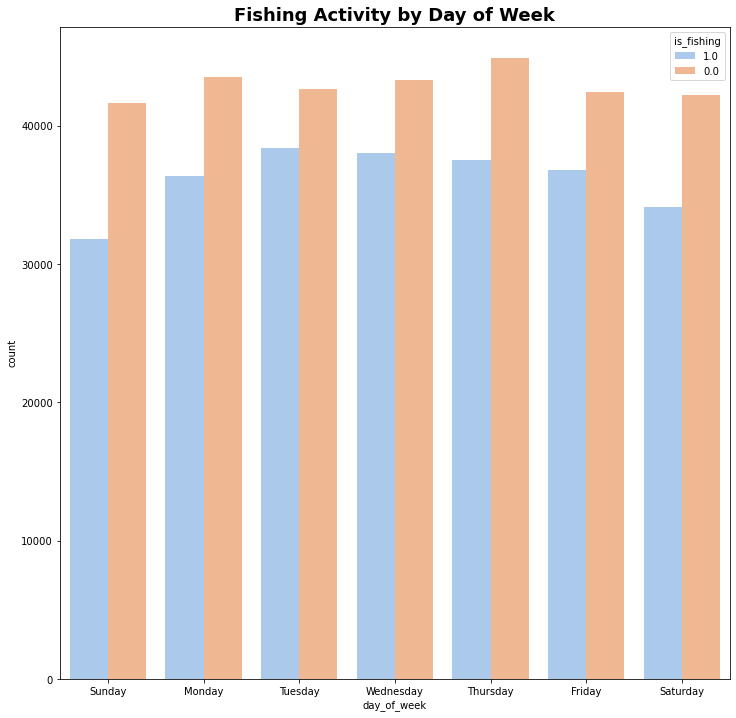

In [206]:
# fishing activity by day of the week 
plt.figure(figsize = (12, 12))
ax = sns.countplot(
    data = combined_df, 
    x = 'day_of_week', 
    hue = 'is_fishing',
    hue_order = [1.0, 0.0], 
    order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
    palette = 'pastel'
)
plt.title('Fishing Activity by Day of Week', fontdict = {'fontsize': 18, 'fontweight': 'bold'})

Text(0.5, 1.0, 'Fishing Activity by Month')

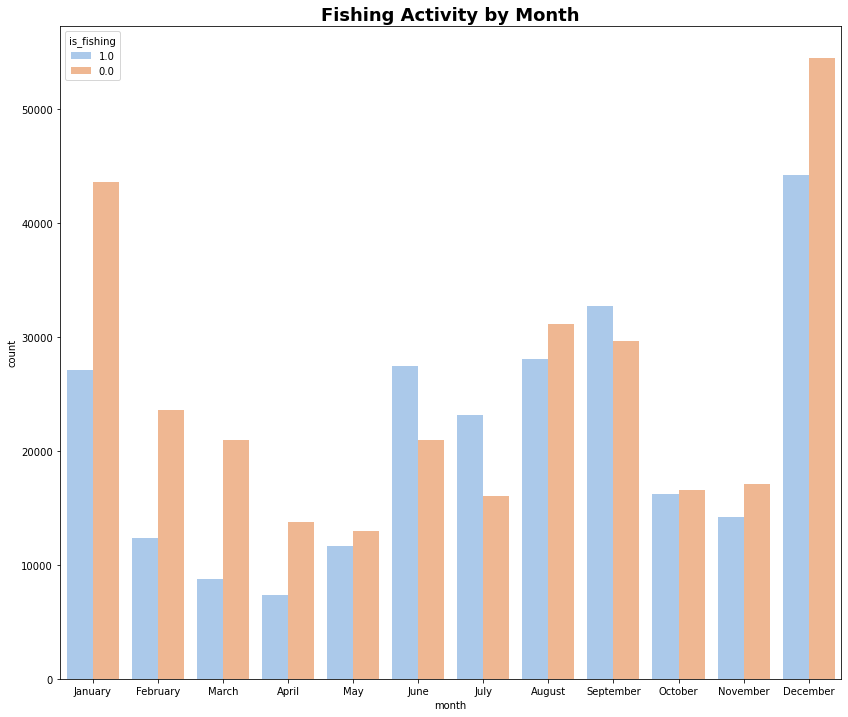

In [207]:
# fishing activity by month 
plt.figure(figsize = (14, 12))
ax = sns.countplot(
    data = combined_df, 
    x = 'month', 
    hue = 'is_fishing',
    hue_order = [1.0, 0.0], 
    order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
    palette = 'pastel'
)
plt.title('Fishing Activity by Month', fontdict = {'fontsize': 18, 'fontweight': 'bold'})

Text(0.5, 1.0, 'Fishing Activity by Hour (24 hour format)')

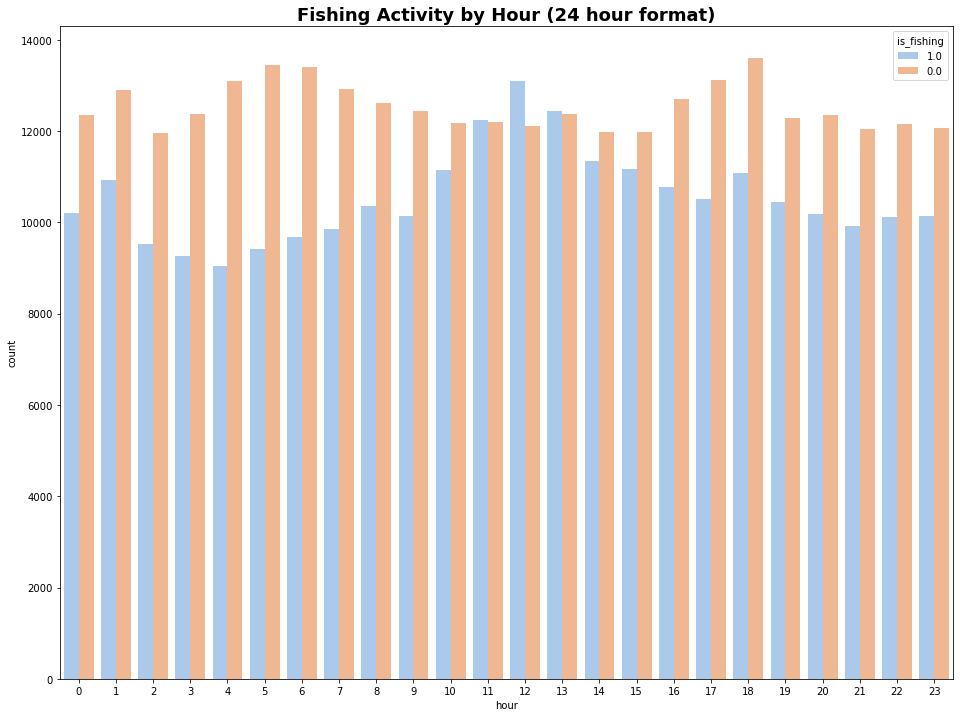

In [208]:
# fishing activity by hour 
plt.figure(figsize = (16, 12))
ax = sns.countplot(
    data = combined_df, 
    x = 'hour', 
    hue = 'is_fishing',
    hue_order = [1.0, 0.0], 
    order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
    palette = 'pastel'
)
plt.title('Fishing Activity by Hour (24 hour format)', fontdict = {'fontsize': 18, 'fontweight': 'bold'})

Text(0.5, 1.0, 'Fishing Activity by Year')

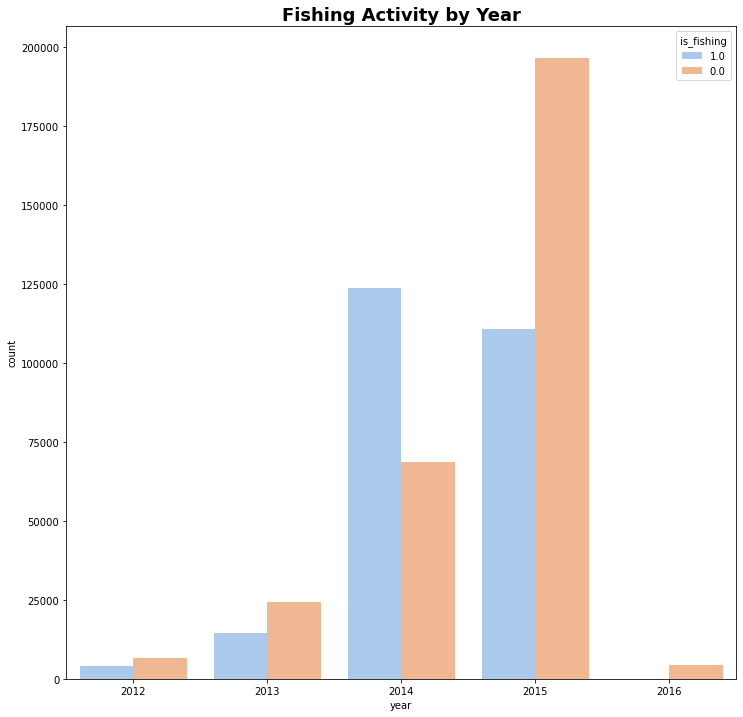

In [209]:
# fishing activity by year 
# this plot doesn't tell us much, sample of data is not representative of all vessels on the water in each year 
plt.figure(figsize = (12, 12))
ax = sns.countplot(
    data = combined_df, 
    x = 'year', 
    hue = 'is_fishing',
    hue_order = [1.0, 0.0], 
    order = [2012, 2013, 2014, 2015, 2016],
    palette = 'pastel'
)
plt.title('Fishing Activity by Year', fontdict = {'fontsize': 18, 'fontweight': 'bold'})

## Sort Data

Now we need to group the training data by `mmsi` and then sort by `timestamp` in chronological order. 

In [210]:
combined_df.sort_values(by = ['mmsi', 'timestamp_reformat'], ascending = [True, True])
combined_df

,mmsi,timestamp,timestamp_reformat,year,hour,day_of_week,month,distance_from_shore,distance_from_port,speed,...,is_fishing,source,fishing_type,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown
330,1.263956e+13,1.338658e+09,2012-06-02 17:19:50,2012,17,Saturday,June,111123.328125,147593.812500,8.2,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
423,1.263956e+13,1.340094e+09,2012-06-19 08:12:54,2012,8,Tuesday,June,329078.531250,362363.843750,5.0,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
570,1.263956e+13,1.345706e+09,2012-08-23 07:06:20,2012,7,Thursday,August,86831.046875,196301.062500,0.7,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
638,1.263956e+13,1.346391e+09,2012-08-31 05:24:34,2012,5,Friday,August,98881.343750,166465.140625,4.2,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
677,1.263956e+13,1.346825e+09,2012-09-05 06:11:05,2012,6,Wednesday,September,74247.757812,177480.859375,7.0,...,1.0,dalhousie_longliner,drifting_long_line,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806717,2.698965e+14,1.451399e+09,2015-12-29 14:29:51,2015,14,Tuesday,December,0.000000,55071.328125,0.0,...,1.0,gfw,unknown,0,0,0,0,0,0,1
6806718,2.698965e+14,1.451400e+09,2015-12-29 14:46:08,2015,15,Tuesday,December,0.000000,55071.328125,0.0,...,1.0,gfw,unknown,0,0,0,0,0,0,1
6806719,2.698965e+14,1.451401e+09,2015-12-29 15:02:30,2015,15,Tuesday,December,0.000000,55071.328125,0.0,...,1.0,gfw,unknown,0,0,0,0,0,0,1
6806720,2.698965e+14,1.451402e+09,2015-12-29 15:18:29,2015,15,Tuesday,December,0.000000,55071.328125,0.0,...,1.0,gfw,unknown,0,0,0,0,0,0,1


In order to complete a time series analysis on the data we will need to fit the data into even time intervals. First we need to check how many groups we have and how many records belong to each group. 

In [211]:
mmsi_groups = combined_df.groupby('mmsi')
# how many unique mmsi's are there 
mmsi_groups.ngroups

330

In [212]:
# how many records does each mmsi have 
mmsi_group_sizes = mmsi_groups.size()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(mmsi_group_sizes)

mmsi
1.252340e+12     3482
1.272260e+12       20
1.679642e+12     2872
2.579933e+12     6115
5.020143e+12       15
5.145483e+12     2720
5.601266e+12     2158
6.335158e+12       47
6.676526e+12       40
7.572519e+12     2388
9.924005e+12        1
1.075939e+13      403
1.088051e+13     1563
1.117001e+13       25
1.263956e+13      325
1.634729e+13     8009
1.638403e+13       42
1.650805e+13     2446
1.775611e+13     3105
1.819924e+13      204
1.826980e+13        3
1.848346e+13     1302
1.851794e+13       37
1.914804e+13       12
1.985955e+13     2494
2.000183e+13     3272
2.101065e+13        8
2.123271e+13      526
2.162561e+13       12
2.218362e+13       13
2.340675e+13      600
2.359313e+13     4715
2.377078e+13      130
2.793233e+13      920
2.814426e+13      528
2.820477e+13     3374
3.005494e+13      740
3.037380e+13      733
3.058181e+13      127
3.186568e+13     5637
3.222535e+13     2074
3.326609e+13     2810
3.491170e+13     1800
3.621263e+13       11
3.642780e+13     4568
3.790

We're going to drop any `mmsi` that has less than 10 records. 

In [213]:
mmsi_throwaways = mmsi_group_sizes[mmsi_group_sizes < 10]
# look at the mmsi's with less than 10 records
mmsi_throwaways

mmsi
9.924005e+12     1
1.826980e+13     3
1.914804e+13    12
2.101065e+13     8
2.162561e+13    12
2.218362e+13    13
3.621263e+13    11
4.083411e+13     5
4.095621e+13     5
5.492675e+13     9
6.182047e+13     3
6.455101e+13     2
7.433217e+13     2
8.079808e+13     9
8.126396e+13     2
8.947022e+13    13
9.400902e+13     1
1.039123e+14     8
1.060799e+14    11
1.100141e+14     2
1.246766e+14    12
1.314049e+14    12
1.319931e+14     2
1.335548e+14     2
1.397611e+14     4
1.414009e+14     6
1.480448e+14    14
1.583170e+14     7
1.609231e+14     5
1.652170e+14    13
1.653486e+14    10
1.686984e+14     1
1.833071e+14     8
1.833153e+14     4
1.838128e+14    10
1.934990e+14     5
2.259795e+14    10
2.472845e+14     2
2.473046e+14     2
2.596001e+14     4
2.746770e+14     9
dtype: int64

In [214]:
# check how many rows we are dropping
mmsi_throwaways.sum()

274

In [215]:
# get mmsi's as a list 
mmsi_throwaway_list = list(mmsi_throwaways.index)

# drop the selected rows corresponding to the above identified mmsi's 
combined_df = combined_df[~combined_df['mmsi'].isin(mmsi_throwaway_list)]

In [216]:
# check that the new shape has -274 rows 
combined_df.shape

(553579, 23)

## Additional Data Wrangling

In [217]:
# drop un-needed columns 
train_df = combined_df.drop(['timestamp_reformat', 'day_of_week', 'month', 'year', 'hour', 'source', 'fishing_type'], axis = 1)
train_df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown
330,1.263956e+13,1.338658e+09,111123.328125,147593.812500,8.2,162.800003,18.608902,-17.205967,1.0,1,0,0,0,0,0,0
423,1.263956e+13,1.340094e+09,329078.531250,362363.843750,5.0,333.899994,18.839836,-19.453779,1.0,1,0,0,0,0,0,0
570,1.263956e+13,1.345706e+09,86831.046875,196301.062500,0.7,260.100006,19.276720,-17.323196,1.0,1,0,0,0,0,0,0
638,1.263956e+13,1.346391e+09,98881.343750,166465.140625,4.2,43.400002,18.852455,-17.255033,1.0,1,0,0,0,0,0,0
677,1.263956e+13,1.346825e+09,74247.757812,177480.859375,7.0,333.500000,19.101482,-17.147205,1.0,1,0,0,0,0,0,0


In [218]:
# check for rows with invalid course values 
train_df[train_df['course'] > 360]

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown
515579,1.061505e+14,1.425173e+09,0.000000,26248.166016,0.0,511.0,50.240002,-3.765000,0.0,0,1,0,0,0,0,0
539442,1.061505e+14,1.448969e+09,0.000000,26248.166016,0.0,511.0,50.240002,-3.765000,0.0,0,1,0,0,0,0,0
539448,1.061505e+14,1.448975e+09,0.000000,26248.166016,0.0,511.0,50.240002,-3.765000,0.0,0,1,0,0,0,0,0
539493,1.061505e+14,1.449017e+09,0.000000,26248.166016,0.0,511.0,50.240002,-3.765000,0.0,0,1,0,0,0,0,0
539495,1.061505e+14,1.449019e+09,0.000000,26248.166016,0.0,511.0,50.240002,-3.765000,0.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5810720,1.337471e+14,1.449222e+09,2236.013184,47295.777344,8.0,511.0,44.689999,14.798333,1.0,0,0,0,0,0,0,1
5810766,1.337471e+14,1.449265e+09,999.975464,88003.523438,0.0,511.0,44.525002,14.435000,0.0,0,0,0,0,0,0,1
5810769,1.337471e+14,1.449268e+09,999.975464,88003.523438,0.0,511.0,44.525002,14.435000,0.0,0,0,0,0,0,0,1
5810776,1.337471e+14,1.449273e+09,999.975464,88003.523438,0.0,511.0,44.525002,14.435000,0.0,0,0,0,0,0,0,1


In [219]:
def fill_course(row):
    '''For each row with invalid course value, find the most similar similar row (through euclidean distance) 
       with a valid course value and take that course value
    '''
    if row['course'] <= 360:
        return row 
    else: 
        ary = scipy.spatial.distance.cdist(train_df[train_df['course'] <= 360], row.to_frame().transpose(), metric = 'euclidean')
        row['course'] = train_df[train_df['course'] <= 360].loc[ary == ary.min()]['course']
        return row

# train_df[train_df['course'] > 360].apply(fill_course, axis = 1)
train_df = train_df.apply(fill_course, axis = 1)

# recheck if any invalid course values are left 
train_df[train_df['course'] > 360]

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown


## Fix Time Steps  

Ships may ping AIS receivers at irregular intervals. This can happen for multiple reasons. On top of that, the data provided is just a sample, so there is almost certainly irregular time intervals present in the data. To account for this, we will resample the data into hourly time intervals. If there are multiple data points in one hour the mean values will be taken. Missing data points will be interpolated from the nearest valid data points.  

Once the model is trained using resampled data, all future training or testing data will have to be resampled to regular hourly intervals. 

In [220]:
def to_unix_time(timestamp: datetime):
    return time.mktime(timestamp.timetuple())

def with_fixed_time_steps(data):
    return (
        data
        .assign(timestamp = lambda df : df['timestamp'].map(datetime.utcfromtimestamp).values)
        .resample(TIME_STEP, on = 'timestamp')
        .mean()
        .reset_index()
        .assign(timestamp = lambda df : df['timestamp'].map(to_unix_time))
        .interpolate()
    )

In [221]:
train_df = with_fixed_time_steps(train_df)
train_df

,timestamp,mmsi,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown
0,1.325426e+09,2.748501e+14,1999.950928,27891.966797,0.061538,127.707689,8.635325,-79.598665,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.325430e+09,2.731665e+14,1981.055054,27198.773264,0.060629,134.652603,9.119915,-77.545302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.325434e+09,2.714828e+14,1962.159180,26505.579732,0.059719,141.597516,9.604505,-75.491939,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.325437e+09,2.697991e+14,1943.263306,25812.386199,0.058809,148.542429,10.089094,-73.438576,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.325441e+09,2.681154e+14,1924.367432,25119.192666,0.057899,155.487342,10.573684,-71.385213,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40963,1.472890e+09,1.127179e+14,17888.105469,25317.357422,9.100000,35.099998,-32.950928,152.004288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40964,1.472893e+09,1.127179e+14,10800.041748,36038.717773,9.437500,48.200000,-32.874472,152.099062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40965,1.472897e+09,1.127179e+14,4076.004541,49397.138672,8.620000,45.890001,-32.785105,152.196635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40966,1.472900e+09,1.127179e+14,4382.476829,67301.159091,9.281818,43.609091,-32.675724,152.309430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Now that the time windows have been normalized to 1 hour gaps, let's peak at the new timestamps in a human readable format.

In [222]:
time_df = train_df[['mmsi', 'timestamp']].copy()
time_df

,mmsi,timestamp
0,2.748501e+14,1.325426e+09
1,2.731665e+14,1.325430e+09
2,2.714828e+14,1.325434e+09
3,2.697991e+14,1.325437e+09
4,2.681154e+14,1.325441e+09
...,...,...
40963,1.127179e+14,1.472890e+09
40964,1.127179e+14,1.472893e+09
40965,1.127179e+14,1.472897e+09
40966,1.127179e+14,1.472900e+09


In [223]:
combined_timestamps = pd.to_datetime(time_df['timestamp'], unit = 's')
time_df.insert(1, 'timestamp_reformat', combined_timestamps)
time_df.head()

,mmsi,timestamp_reformat,timestamp
0,2.748501e+14,2012-01-01 14:00:00,1.325426e+09
1,2.731665e+14,2012-01-01 15:00:00,1.325430e+09
2,2.714828e+14,2012-01-01 16:00:00,1.325434e+09
3,2.697991e+14,2012-01-01 17:00:00,1.325437e+09
4,2.681154e+14,2012-01-01 18:00:00,1.325441e+09


In [224]:
# add separate month, day of the week, year, and hour columns derived from timstamps
time_df.insert(2, 'year', time_df['timestamp_reformat'].dt.year)
# round to closest hour 
time_df.insert(3, 'hour', time_df['timestamp_reformat'].dt.round('H').dt.hour)
time_df.insert(4, 'day_of_week', time_df['timestamp_reformat'].dt.day_name())
time_df.insert(5, 'month', time_df['timestamp_reformat'].dt.month_name())

time_df

,mmsi,timestamp_reformat,year,hour,day_of_week,month,timestamp
0,2.748501e+14,2012-01-01 14:00:00,2012,14,Sunday,January,1.325426e+09
1,2.731665e+14,2012-01-01 15:00:00,2012,15,Sunday,January,1.325430e+09
2,2.714828e+14,2012-01-01 16:00:00,2012,16,Sunday,January,1.325434e+09
3,2.697991e+14,2012-01-01 17:00:00,2012,17,Sunday,January,1.325437e+09
4,2.681154e+14,2012-01-01 18:00:00,2012,18,Sunday,January,1.325441e+09
...,...,...,...,...,...,...,...
40963,1.127179e+14,2016-09-03 08:00:00,2016,8,Saturday,September,1.472890e+09
40964,1.127179e+14,2016-09-03 09:00:00,2016,9,Saturday,September,1.472893e+09
40965,1.127179e+14,2016-09-03 10:00:00,2016,10,Saturday,September,1.472897e+09
40966,1.127179e+14,2016-09-03 11:00:00,2016,11,Saturday,September,1.472900e+09


# Final Data Wrangling / Exploratory Analysis

In [225]:
# final check on course values
train_df['course'].isnull().sum()

0

In [226]:
train_df.head()

,timestamp,mmsi,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown
0,1.325426e+09,2.748501e+14,1999.950928,27891.966797,0.061538,127.707689,8.635325,-79.598665,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.325430e+09,2.731665e+14,1981.055054,27198.773264,0.060629,134.652603,9.119915,-77.545302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.325434e+09,2.714828e+14,1962.159180,26505.579732,0.059719,141.597516,9.604505,-75.491939,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.325437e+09,2.697991e+14,1943.263306,25812.386199,0.058809,148.542429,10.089094,-73.438576,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.325441e+09,2.681154e+14,1924.367432,25119.192666,0.057899,155.487342,10.573684,-71.385213,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [227]:
# recheck label distribution 
train_df['is_fishing'].value_counts()

0.000000    16306
1.000000     4894
0.500000     1910
0.333333      917
0.666667      715
            ...  
0.298507        1
0.701149        1
0.898305        1
0.168605        1
0.443182        1
Name: is_fishing, Length: 2351, dtype: int64

After resampling, need to re-simplify labels. 

In [228]:
train_df.loc[train_df['is_fishing'] >= 0.5, 'is_fishing'] = 1.0
train_df.loc[train_df['is_fishing'] < 0.5, 'is_fishing'] = 0.0

train_df['is_fishing'].value_counts()

0.0    26308
1.0    14660
Name: is_fishing, dtype: int64

In [229]:
train_df.columns

Index(['timestamp', 'mmsi', 'distance_from_shore', 'distance_from_port',
       'speed', 'course', 'lat', 'lon', 'is_fishing', 'drifting_long_line',
       'fixed_gear', 'pole_line', 'purse_seines', 'trawler', 'troller',
       'unknown'],
      dtype='object')

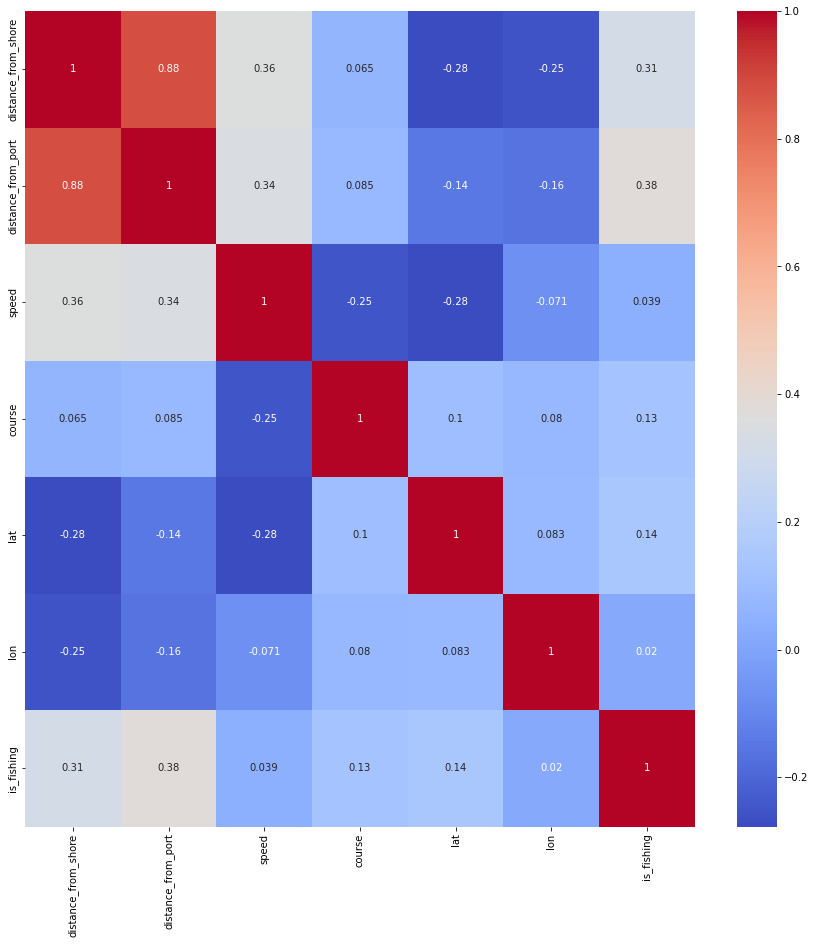

In [230]:
# correlation heatmap 
corr_df = train_df.drop(['mmsi', 'timestamp', 'drifting_long_line', 'fixed_gear', 'pole_line', 'purse_seines', 'trawler', 'troller', 'unknown'], axis = 1).corr()
plt.figure(figsize = (15, 15))
ax = sns.heatmap(corr_df, annot = True, cmap = 'coolwarm')

Looking at the corerlation heatmap, `distance_from_port` and `distance_from_shore` are highly correlated so we will only need one of them. We'll drop `distance_from_shore`. We can drop the `mmsi` column as well. 

In [231]:
train_df = train_df.drop(['mmsi', 'distance_from_shore'], axis = 1)
train_df

,timestamp,distance_from_port,speed,course,lat,lon,is_fishing,drifting_long_line,fixed_gear,pole_line,purse_seines,trawler,troller,unknown
0,1.325426e+09,27891.966797,0.061538,127.707689,8.635325,-79.598665,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.325430e+09,27198.773264,0.060629,134.652603,9.119915,-77.545302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.325434e+09,26505.579732,0.059719,141.597516,9.604505,-75.491939,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.325437e+09,25812.386199,0.058809,148.542429,10.089094,-73.438576,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.325441e+09,25119.192666,0.057899,155.487342,10.573684,-71.385213,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40963,1.472890e+09,25317.357422,9.100000,35.099998,-32.950928,152.004288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40964,1.472893e+09,36038.717773,9.437500,48.200000,-32.874472,152.099062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40965,1.472897e+09,49397.138672,8.620000,45.890001,-32.785105,152.196635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40966,1.472900e+09,67301.159091,9.281818,43.609091,-32.675724,152.309430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Split Into Train/Test Sets  

Since we are working with time series data, we cannot randomly split the data as we would do with a regular classificaiton problem. The sequence of data in hourly time intervals is part of the feature space. 

In [232]:
# 75/25 training test split 
training_size = int(len(train_df) * 0.75)
test_size = len(train_df) - training_size

# get labels from train_df and then drop is_fishing
labels = train_df['is_fishing']
train_df = train_df.drop('is_fishing', axis = 1)

In [237]:
x_train = train_df[0:training_size] 
y_train = labels[0:training_size]

x_test = train_df[training_size:len(train_df)]
y_test = train_df[training_size:len(train_df)]

# Modeling